In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_, distinct, desc
from datetime import datetime, timedelta


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Looking for the column names to know where to query from
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print(f'Table: {table_name}')
    print("----------")
    for column in inspector.get_columns(table_name):
        print(column['name'])

Table: measurement
----------
id
station
date
prcp
tobs
Table: station
----------
id
station
name
latitude
longitude
elevation


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# First, we need to know the max and min date to filter proper values
max_date = session.query(func.max(measure.date)).scalar()
min_date = session.query(func.min(measure.date)).scalar()
print(f"""The max date is {max_date},
The min date is {min_date}""")

The max date is 2017-08-23,
The min date is 2010-01-01


In [12]:
# Then we can do the query
date_filter = session.query(measure).filter(
        and_(measure.date <= '2017-08-23', measure.date >= '2016-08-23'))

In [13]:
# Calculate the date 1 year ago from the last data point in the database
dt.date(2017, 8, 23) - timedelta(days=365)

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
dataquery = engine.execute("SELECT * FROM measurement").fetchall()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.read_sql_query("SELECT * FROM measurement", engine)
prec_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [16]:
# Sort the dataframe by date
prec_df = prec_df.sort_values(by="date")
prec_df.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
9007,9008,USC00518838,2010-01-01,0.21,72.0
9518,9519,USC00519523,2010-01-01,0.15,75.0
12187,12188,USC00519281,2010-01-01,0.15,70.0
14959,14960,USC00511918,2010-01-01,0.05,66.0


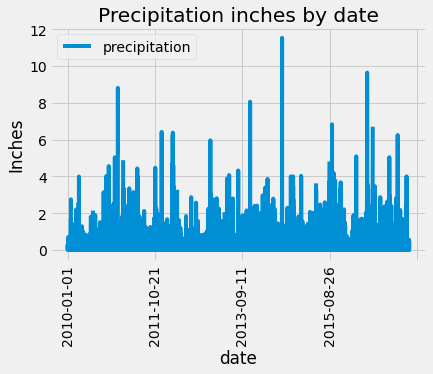

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plot of the whole database
prec_df.plot(x='date',y='prcp', label='precipitation')
plt.title("Precipitation inches by date")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
plt.legend(loc="best")
plt.show()

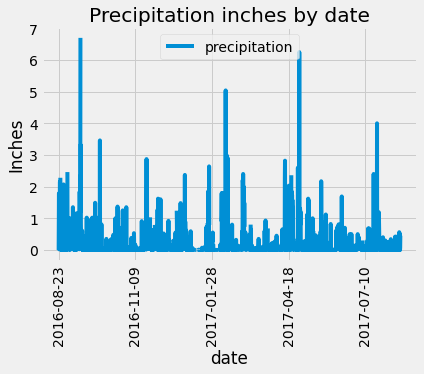

In [18]:
# Plot of filtered year
filtered_df = prec_df.loc[prec_df["date"]>="2016-08-23"]
filtered_df.plot(x='date',y='prcp', label='precipitation')
plt.title("Precipitation inches by date")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
plt.legend(loc="best")
plt.locator_params(axis="x", nbins=9)
plt.locator_params(axis="y", nbins=8)
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,id,prcp,tobs
count,19550.000000,18103.000000,19550.000000
mean,9775.500000,0.160644,73.097954
std,5643.743217,0.468746,4.523527
min,1.000000,0.000000,53.000000
25%,4888.250000,0.000000,70.000000
50%,9775.500000,0.010000,73.000000
75%,14662.750000,0.110000,76.000000
max,19550.000000,11.530000,87.000000


### Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?
# Using normal and distinct count produce the same result.
session.query(func.count(distinct(station.station))).scalar()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df = pd.read_sql_query("SELECT * FROM measurement", engine)
station_df.groupby("station").count()["tobs"].to_frame().sort_values(by="tobs", ascending=False)

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [22]:
temp_count = session.query(measure.station, func.count(measure.tobs).label("tobs")).group_by(measure.station).order_by(desc("tobs")).all()
temp_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Highest temperature:
session.query(measure.tobs, func.max(measure.tobs).filter(measure.station == "USC00519281")).scalar()

85.0

In [24]:
# Lowest temperature: 
session.query(measure.tobs, func.min(measure.tobs).filter(measure.station == "USC00519281")).scalar()

54.0

In [25]:
# Average temperature:
session.query(measure.tobs, func.avg(measure.tobs).filter(measure.station == "USC00519281")).scalar()

65.0

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_df = prec_df.loc[(prec_df["station"] == "USC00519281") & (prec_df["date"] >= "2016-08-23")]
station_df

,id,station,date,prcp,tobs
14607,14608,USC00519281,2016-08-23,1.79,77.0
14608,14609,USC00519281,2016-08-24,2.15,77.0
14609,14610,USC00519281,2016-08-25,0.06,80.0
14610,14611,USC00519281,2016-08-26,0.01,80.0
14611,14612,USC00519281,2016-08-27,0.12,75.0
...,...,...,...,...,...
14954,14955,USC00519281,2017-08-14,0.00,77.0
14955,14956,USC00519281,2017-08-15,0.32,77.0
14956,14957,USC00519281,2017-08-16,0.12,76.0
14957,14958,USC00519281,2017-08-17,0.01,76.0


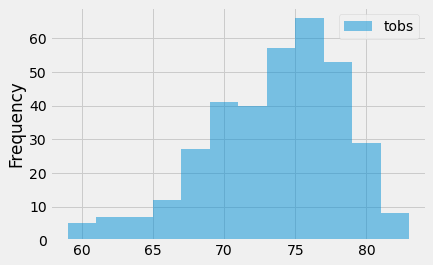

In [56]:
hist_data = pd.DataFrame(station_df["tobs"])
hist_data.plot.hist(bins=12, alpha=0.5)
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
